In [48]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Literal, Annotated
from langchain_core.messages import SystemMessage, HumanMessage

In [49]:
generator_llm = ChatOpenAI(model = 'gpt-4o')
evaluator_llm = ChatOpenAI(model = 'gpt-4o-mini')
optimizer_llm = ChatOpenAI(model = 'gpt-4o')

In [50]:
from pydantic import BaseModel, Field
class TweetEvaluation(BaseModel) :
    evaluation: Literal['approved',"needs_improvement"] = Field(..., description="Final evaluation")
    feedback : str = Field(..., description="feedback for the tweet.")

In [51]:
structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [52]:
# State
class TweetState(TypedDict) :
    topic : str
    tweet : str
    evaluation : Literal['approved','needs_improvement']
    feedback : str
    iteration : int
    max_iteration : int  

In [53]:
def generate_tweet(state: TweetState) :
    # prompt
    message = [
        SystemMessage(content = "You are a funny and clever Twiiter/X influncer."),
        HumanMessage(content = f"""
        Write a short, original , and hilarious tweer on the topic : "{state['topic']}".
            Rules : 
            - Do not use question answer format.
            - max 250 characters.
            - use observation humor, irony, sarcasm, or cultural reference.
            - THink in meme logic, punchlines, or relatable takes.
            - Use simple day to day english.
            - THis is version {state['iteration'] + 1}
            """
            )
    ]

    # invoke generate_llm
    response = generator_llm.invoke(message).content

    # return response
    return {"tweet" : response}

In [54]:
def evaluate_tweet(state: TweetState) :
    # prompt
    message = [
        SystemMessage(content = "You are a ruthless, no laugh given Twitter critic. You evaluate tweets based on humor, originality, virality and tweet format."),
        HumanMessage(content = f"""
        Evaluate the following tweet :
        
        Tweet: "{state['tweet']}"

        Use the criteria below to evaluate the tweet : 

        1. Originality - is this fresh, or have you seen it a hundred times before ?
        2. Humor - Did it genuinely make you smile, laugh, or chuckle?
        3. Punchines - Is it short, sharp, and scroll-stopping?
        4. Virality Potential - Would people retweet or share it ?
        5. Format  - Is it a well formated tweet (not a setup puncline joke, not a Q&A joke, and under 280 characters) ?

        Auto reject if :
        - It's written in question-answer format (e.g. "Why did..." or "What happens when...")
        - it exceed 280 characters 
        - IT reads like a traditional setup-punchline joke.
        -Dont read with generic , throaway, or deflating line that weaken the humor (e.g. "Masterpiece of the auntie-uncle unvierse" or "vague summaries")

        ### Respond ONLY in structured format :
        - evaluation : "approved" or "needs_imporvement"
        -feedback : one paragraph explaining the strengths and weaknesses
        """)
    ]

    # invoke evaluate_llm
    response = structured_evaluator_llm.invoke(message)

    # return response
    return {"evaluation" : response.evaluation,
            "feedback" : response.feedback}

In [55]:
def optimize_tweet(state : TweetState) :
    message = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content = f"""
        Improve the tweet based on this  feedback :
            "{state['feedback']}"

        Topic : "{state['topic']}"
        Original Tweet : "{state['tweet']}"
        Rewrite it as a short, vital-worthy tweet. Avoid Q&A style and stay under 280 characters.
            """
        )
    ]

    response  = optimizer_llm.invoke(message) .content  
    iteration = state['iteration'] + 1
    return {'tweet' : response, 'iteration' : iteration}

In [56]:
def route_evaluation(state: TweetState) :
    if (state['evaluation'] == "approved") or (state['iteration'] >= 5) :
        return "approved"
    else :
        return "need_improvement"

In [57]:
graph = StateGraph(TweetState)

graph.add_node('generate', generate_tweet)
graph.add_node('evaluate', evaluate_tweet)
graph.add_node('optimize', optimize_tweet)

graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')

graph.add_conditional_edges('evaluate', route_evaluation, {'approved' : END, "need_improvement": 'optimize'} )
graph.add_edge('optimize', 'evaluate')

workflow = graph.compile()

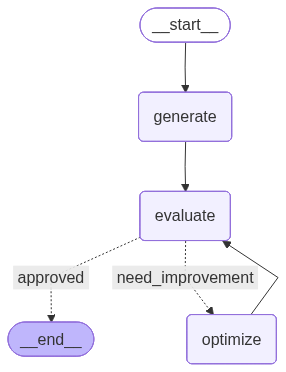

In [58]:
workflow

In [61]:
intital_state = {
    'topic' : ' Indian Railways',
    'iteration' : 1,
     'max_iteration' : 5
}
workflow.invoke(intital_state)

{'topic': ' Indian Railways',
 'tweet': 'Indian Railways: Where "on time" means "Why rush?" 🕒 Catch your train, catch a delay—same thing! It’s like a universal reminder to slow down, because even the trains are taking it easy. 🚂😂 #ChillRailways',
 'evaluation': 'approved',
 'feedback': "This tweet leverages the relatable experience of delays with Indian Railways in a clever and humorous way. The use of the phrase 'universal reminder to slow down' adds an original twist, enhancing its originality. The humor is effective, eliciting a chuckle without relying on tired formats, and the emojis add a lighthearted touch. The punchlines are sharp and the format adheres to Twitter guidelines, making it easily shareable. Overall, it's engaging and likely to resonate with many users, enhancing its virality potential.",
 'iteration': 2,
 'max_iteration': 5}